In [2]:
import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
from tqdm import tqdm

from plotting import label_axes

In [3]:
# constants
mpic2 = 134.9768 * u.MeV
mpc2 = (const.m_p * const.c**2).to(u.GeV)
mec2 = (const.m_e * const.c**2).to(u.MeV)

In [4]:
n_H = 4 / (u.cm**3)
K_pi = 0.17  # mean multiplicity for delta-approximation, we will assume that E_pi = K_pi * E_p

In [5]:
alpha = 2.4

def spectral_density(
    E: u.Quantity[u.eV], n_0: u.Quantity[1 / u.eV]
) -> u.Quantity[1 / u.eV]:
    return n_0 * ((E / u.TeV).to(u.dimensionless_unscaled)).value ** (-alpha)

# Problem statement

Given a source with identical-spectrum populations of $e^-$ and $p$, compute $W_e / W_p$ under condition of $Q_e = Q_p$ at $E = 1~\text{TeV}$

## Proton-induced $\gamma$-ray emissivity

### $p + p \to \pi_0 + X$ cross-section

Total cross-section is given in 
```
Norbury, J. W. (2009). Total cross section parameterizations for pion production in nucleon–nucleon collisions. In Nuclear Instruments and Methods in Physics Research Section B: Beam Interactions with Materials and Atoms (Vol. 267, Issue 7, pp. 1209–1212). Elsevier BV. https://doi.org/10.1016/j.nimb.2009.02.067
```

high energy sigma_pp limit = 142.8571005647761 mbarn


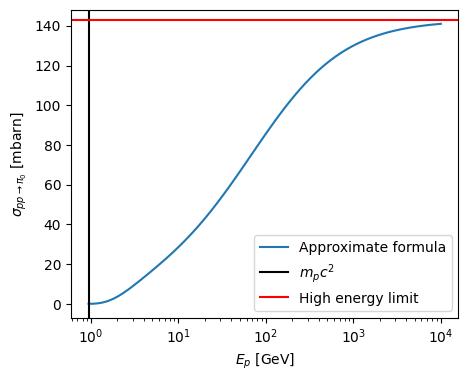

In [6]:
def sigma_pp_pi0(E_p: u.Quantity[u.eV]) -> u.Quantity[u.mbarn]:
    T_lab = (E_p - mpc2).to(u.GeV).value

    HIGH_E_THRESHOLD = 1e9  # GeV
    overflow_mask = T_lab > HIGH_E_THRESHOLD
    T_lab[overflow_mask] = HIGH_E_THRESHOLD

    positive_mask = T_lab > 0
    T_lab_pos = T_lab[positive_mask]
    res = np.zeros_like(T_lab) * u.mbarn
    res[positive_mask] = (
        (0.007 + 0.1 * np.log(T_lab_pos) / T_lab_pos + 0.3 / (T_lab_pos**2)) ** (-1)
    ) * u.mbarn
    return res


sigma_pp_pi0_high_energy = sigma_pp_pi0(np.array([1000]) * u.PeV)[0]
print(f"high energy sigma_pp limit = {sigma_pp_pi0_high_energy}")

_, ax = plt.subplots(figsize=(5, 4))

E_grid = np.logspace(np.log10(mpc2.to(u.GeV).value), 4, 100) * u.GeV
ax.plot(E_grid, sigma_pp_pi0(E_grid), label="Approximate formula")
ax.axvline(mpc2, color="k", label="$m_p c^2$")
ax.set_xscale("log")
ax.axhline(sigma_pp_pi0_high_energy, color="r", label="High energy limit")
label_axes(ax, "E_{p}", "\\sigma_{pp \\to \\pi_0}")
ax.legend()
plt.show()

Differential cross-section is given by total cross section and a phenomenological shape function

/Users/njvh/Documents/Science/GSSI/HEAPTH/exam/venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


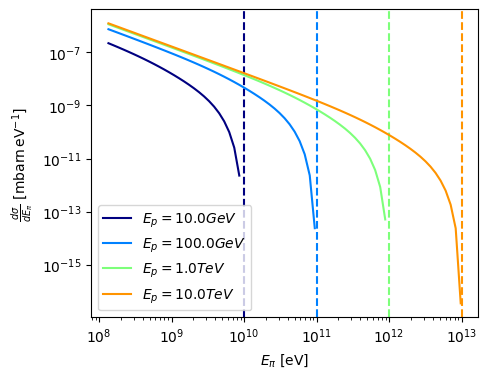

In [7]:
def diff_cross_section_f(x: np.ndarray | float) -> np.ndarray:
    return 0.67 * (1 - x) ** 3.5 + 0.5 * np.exp(-18 * x)


def dsigma_dEpi(
    E_p: u.Quantity[u.eV], E_pi: u.Quantity[u.eV]
) -> u.Quantity[u.mbarn / u.eV]:
    assert E_p.size == 1
    total = sigma_pp_pi0(u.Quantity([E_p]))
    shape = diff_cross_section_f(E_pi / E_p)
    return (total * shape / E_pi).to(u.mbarn / u.eV)


_, ax = plt.subplots(figsize=(5, 4))
E_p_grid = [10 * u.GeV, 100 * u.GeV, 1 * u.TeV, 10 * u.TeV]
E_pi_grid = np.logspace(np.log10(mpic2.to(u.eV).value), 15, 100) * u.eV
cmap = matplotlib.colormaps["jet"]
for idx, E_p in enumerate(E_p_grid):
    color = cmap(idx / len(E_p_grid))
    ax.loglog(E_pi_grid, dsigma_dEpi(E_p=E_p, E_pi=E_pi_grid), label=f"$ E_{{p}} = {E_p} $", color=color)
    ax.axvline(E_p, linestyle="--", color=color)
ax.legend()
label_axes(ax, "E_{\\pi}", "\\frac{d \\sigma}{dE_\\pi}")
plt.show()

In [8]:
Y_alpha, _ = scipy.integrate.quad(
    lambda x: diff_cross_section_f(x) * x ** (alpha - 2), a=0, b=1
)
print(f"{Y_alpha = }")

Y_alpha = 0.07603554023318222


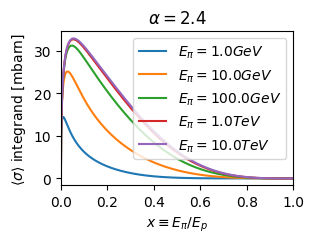

In [9]:
def sigma_average_integrand(
    x_grid: np.ndarray | float,
    E_pi: u.Quantity[u.eV],
) -> u.Quantity[u.mbarn]:

    def _internal(x_grid):
        return (
            diff_cross_section_f(x_grid)
            * x_grid ** (alpha - 2)
            * sigma_pp_pi0(E_pi / x_grid)
        )

    if E_pi.size != 1:
        raise ValueError("E_pi must be scalar")
    if isinstance(x_grid, float):
        return _internal(x_grid) if 0 < x_grid < 1 else 0
    else:
        result = np.zeros_like(x_grid) * u.mbarn
        mask = np.logical_and(x_grid > 0, x_grid < 1)
        result[mask] = _internal(x_grid[mask])
        return result


_, ax = plt.subplots(figsize=(3, 2))
x_grid = np.linspace(0, 1, 1000)
E_pi_grid = [1 * u.GeV, 10 * u.GeV, 100 * u.GeV, 1 * u.TeV, 10 * u.TeV]
for E_pi in E_pi_grid:
    ax.plot(x_grid, sigma_average_integrand(x_grid, E_pi), label=f"$E_\\pi = {E_pi}$")
label_axes(ax, "x \\equiv E_\\pi / E_p", "\\langle \\sigma \\rangle~\\text{integrand}")
ax.set_title(f"$\\alpha = {alpha}$")
ax.set_xlim(0, 1)
ax.legend()
plt.show()

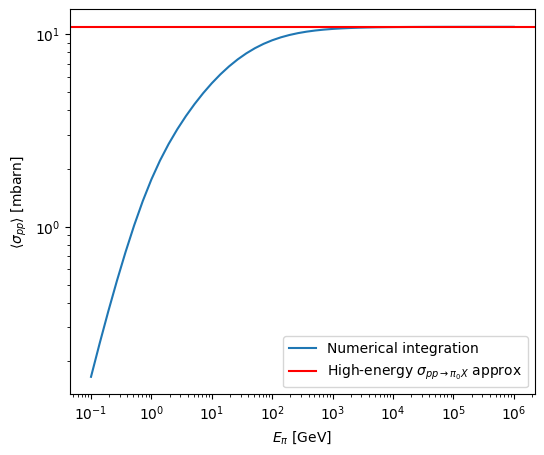

In [10]:
def sigma_average(E_pi: u.Quantity[u.eV]) -> u.Quantity[u.mbarn]:
    res: list[float] = []
    for E_pi_ in E_pi:
        value, _ = scipy.integrate.quad(
            lambda x: sigma_average_integrand(x, E_pi=u.Quantity([E_pi_])).to(u.mbarn).value,
            a=0,
            b=1,
        )
        res.append(value)
    return np.array(res) * u.mbarn


_, ax = plt.subplots(figsize=(6, 5))

E_pi_grid = np.logspace(-1, 6, 50) * u.GeV
ax.loglog(E_pi_grid, sigma_average(E_pi_grid), label="Numerical integration")


ax.axhline(
    Y_alpha * sigma_pp_pi0_high_energy,
    color="r",
    label=f"High-energy $ \\sigma_{{pp \\to \\pi_0 X}} $ approx",
)

label_axes(ax, "E_\\pi", "\\langle \\sigma_{pp} \\rangle")
ax.legend()
plt.show()

### $\pi_0$ emissivity

There are 3 approximations:
- $\delta$-approximation, with $\frac{d \sigma_{pp \to \pi_0 X}}{dE_\pi}$ only "selecting" $E_\pi = K_\pi E_p$ with $K_\pi \approx 0.17$
- based on $\langle \sigma_{pp} \rangle(\alpha, E_\pi)$ above, obtained through numerical integration
- Carmelo's formula (p. 26 of lectures) corresponding to a high-energy limit of $\langle \sigma_{pp} \rangle$

In [11]:
from typing import Literal

EMISSIVITY = 1 / (u.eV * u.yr)


def q_pi(
    E_pi_grid: u.Quantity[u.eV],
    n_0: u.Quantity[1 / u.eV],
    method: Literal["delta", "high-e-sigma", "num-int"],
) -> u.Quantity[EMISSIVITY]:
    norm = const.c * n_H
    if method == "delta":
        exact_E_p_grid = mpc2 + (E_pi_grid - mpic2) / K_pi
        return (
            (norm / K_pi)
            * sigma_pp_pi0(exact_E_p_grid)
            * spectral_density(E=exact_E_p_grid, n_0=n_0)
        ).to(EMISSIVITY)
    elif method == "num-int":
        return norm * spectral_density(E=E_pi_grid, n_0=n_0) * sigma_average(E_pi_grid)
    elif method == "high-e-sigma":
        return (
            norm
            * spectral_density(E=E_pi_grid, n_0=n_0)
            * Y_alpha
            * sigma_pp_pi0_high_energy
        )
    else:
        raise ValueError(f"Unexpected method: {method!r}")

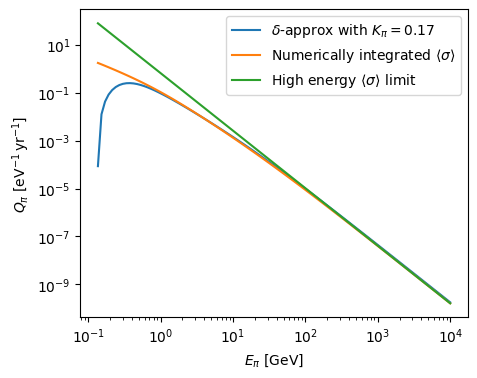

In [12]:
n_0p_example = 1 / u.eV
E_pi_grid = np.logspace(np.log10(1.01 * mpic2.to(u.eV).value), 13, 100) * u.eV

_, ax = plt.subplots(figsize=(5, 4))

exact_E_p_grid = mpc2 + (E_pi_grid - mpic2) / K_pi
ax.loglog(
    E_pi_grid.to(u.GeV),
    q_pi(E_pi_grid, n_0=n_0p_example, method="delta"),
    label=f"$ \\delta $-approx with $ K_\\pi = {K_pi} $",
)

ax.plot(
    E_pi_grid,
    q_pi(E_pi_grid, n_0=n_0p_example, method="num-int"),
    label="Numerically integrated $\\langle \\sigma \\rangle$",
)

ax.plot(
    E_pi_grid,
    q_pi(E_pi_grid, n_0=n_0p_example, method="high-e-sigma"),
    label="High energy $\\langle \\sigma \\rangle$ limit",
)

ax.legend()
label_axes(ax, "E_\\pi", "Q_\\pi")

## Proton-induced $\gamma$-ray emissivity

In [76]:
def q_gamma(
    E_gamma_grid: u.Quantity[u.eV],
    n_0p: u.Quantity[1 / u.eV],
    method: Literal["high-energy", "num-int"],
) -> u.Quantity[EMISSIVITY]:
    if method == "high-energy":
        return (
            (2 / alpha)
            * const.c
            * n_H
            * sigma_pp_pi0_high_energy
            * Y_alpha
            * spectral_density(E_gamma_grid, n_0=n_0p)
        ).to(EMISSIVITY)
    elif method == "num-int":
        res: list[float] = []

        def integrand(log_E_pi_eV: float) -> float:
            E_pi = np.exp(log_E_pi_eV) * u.eV
            if np.isinf(E_pi):
                return 0
            numerator = q_pi(
                E_pi_grid=u.Quantity([E_pi]),
                n_0=n_0p,
                method="num-int",
            )
            denominator = np.sqrt(E_pi**2 - mpic2**2)
            #         VVVV Jacobian or x -> log x transform
            result = (E_pi * numerator / denominator).to(1 / (u.yr * u.eV))
            return result.value

        for E_gamma in tqdm(E_gamma_grid):
            lower_limit = (E_gamma + (mpic2**2) / (4 * E_gamma)).to(u.eV)
            # upper_limit = 1000 * u.TeV
            integrated, _ = scipy.integrate.quad(
                integrand,
                a=np.log(lower_limit.value),
                b=np.inf,
                # b=np.log(upper_limit.value),
            )
            res.append(2 * integrated)
        return np.array(res) * EMISSIVITY

  0%|          | 0/60 [00:00<?, ?it/s]/Users/njvh/Documents/Science/GSSI/HEAPTH/exam/venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in square
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_42232/943179699.py:19: RuntimeWarning: overflow encountered in exp
  E_pi = np.exp(log_E_pi_eV) * u.eV
100%|██████████| 60/60 [01:17<00:00,  1.28s/it]


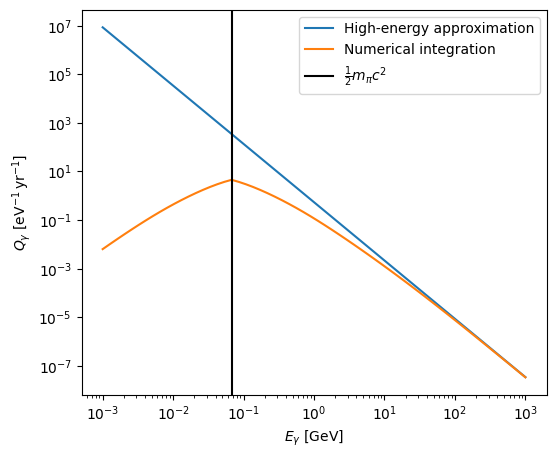

In [14]:
E_gamma_grid = np.logspace(-3, 3, 60) * u.GeV

_, ax = plt.subplots(figsize=(6, 5))

for method, label in (
    ("high-energy", "High-energy approximation"),
    ("num-int", "Numerical integration"),
):
    q_gamma_arr = q_gamma(E_gamma_grid, n_0p=n_0p_example, method=method)
    ax.loglog(
        E_gamma_grid.to(u.GeV),
        q_gamma_arr,
        label=label,
    )

ax.axvline(mpic2 / 2, color="black", label="$ \\frac{1}{2} m_\\pi c^2 $")

ax.legend()
label_axes(ax, "E_\\gamma", "Q_\\gamma")
plt.show()

# Electron-induced $\gamma$-ray emissivity

IC emission happens in two regimes: Thomson and Klein-Nishina. The transition between them is governed by the relation
between $\epsilon^\prime_i = \gamma \epsilon_i$ and electron rest mass $m_e c^2$. Hence, the transition happens
for electrons at $ E_e = \gamma m_e c^2 = \frac{m_e^2 c^4}{\epsilon_i} = \frac{m_e^2 c^4}{k_B T_{\text{CMB}}} $


In [54]:
T_CMB = 2.73 * u.K
eps_i = ((np.pi**4) / (30 * 1.2021) * const.k_B * T_CMB).to(
    u.meV
)  # average CMB photon energy (arXiv:1109.3822)

print(f"Average CMB photon energy: {eps_i:.3f}")

E_e_threshold = ((mec2)**2 / (eps_i)).to(u.PeV)
print(f"Thomson/KN threshold on CMB: {E_e_threshold:.3f}")

Average CMB photon energy: 0.635 meV
Thomson/KN threshold on CMB: 0.411 PeV


We're interested at energies aroung $1$ TeV, so we can safely work in Thomson regime

### Single-electron IC spectrum

In Thomson regime

$$
\epsilon_f = \gamma^2 \epsilon_i (1 + \beta \cos \alpha') (1 - \beta \cos \alpha)
$$

Here:
- $\epsilon_f$ is the energy of IC photon
- $\gamma, \beta$ are Lorentz factor and $v/c$ ratio for electron
- $\epsilon_i$ is the initial energy of photon (in our case CMB)
- $\alpha'$ is a scattering angle in the comoving frame, distributed according to Thomson differential cross-section
- $\alpha$ is an incident angle in lab frame, distributed isotropically

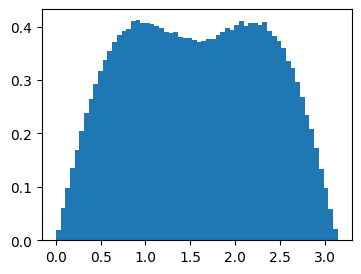

In [17]:
def sample_thomson_angle(size: int) -> np.ndarray:
    cos_sample = np.full(shape=(size,), fill_value=np.nan)
    generate_mask = np.ones(shape=(size,), dtype=bool)
    indices = np.arange(stop=size)
    while size > 0:
        values = np.random.random(size=size) * 2 - 1
        heights = np.random.random(size=size) 
        accepted_submask = ((1 + values ** 2) / 2) > heights
        accepted_indices = indices[generate_mask][accepted_submask]
        cos_sample[accepted_indices] = values[accepted_submask]
        generate_mask[accepted_indices] = False
        size = np.sum(generate_mask)
    return np.arccos(cos_sample)


_, ax = plt.subplots(figsize=(4, 3))
ax.hist(sample_thomson_angle(1_000_000), bins=60, density=True)
plt.show()

average energy of emitted IC photon: 2.428 GeV
expected average: 2.434 GeV


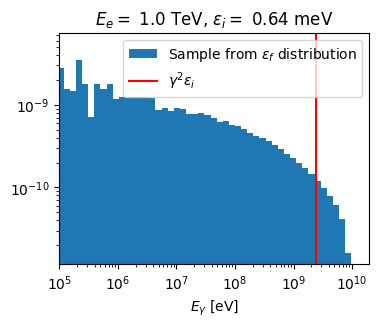

In [51]:
def ic_photon_energy(
    E_e: u.Quantity[u.eV],
    e_i: u.Quantity[u.eV],
    co_scatter_angle: u.Quantity[u.dimensionless_unscaled],
    lab_collision_angle: u.Quantity[u.dimensionless_unscaled],
) -> u.Quantity[u.eV]:
    gamma = (E_e / mec2).decompose()
    beta = 1 - 1 / (gamma**2)
    return (
        gamma**2
        * e_i
        * (1 + beta * np.cos(co_scatter_angle))
        * (1 - beta * np.cos(lab_collision_angle))
    ).to(u.eV)


size = 100_000
alpha_prime_sample = sample_thomson_angle(size)
alpha_sample = np.arccos(np.random.random(size=size) * 2 - 1)
E_e = 1 * u.TeV
E_gamma_sample = ic_photon_energy(
    E_e=E_e,
    e_i=eps_i,
    co_scatter_angle=alpha_prime_sample,
    lab_collision_angle=alpha_sample,
)

_, ax = plt.subplots(figsize=(4, 3))
E_gamma_bins = (
    np.logspace(
        np.log10(E_gamma_sample.min().to(u.eV).value),
        np.log10(E_gamma_sample.max().to(u.eV).value),
        num=60,
    )
    * u.eV
)
print(f"average energy of emitted IC photon: {E_gamma_sample.mean().to(u.GeV):.3f}")
expected_average = ((E_e / mec2) ** 2 * eps_i).to(u.GeV)
print(f"expected average: {expected_average:.3f}")

ax.hist(
    E_gamma_sample,
    bins=E_gamma_bins,
    label="Sample from $\\epsilon_f$ distribution",
    density=True,
)
# ax.plot(E_gamma_bins, 7e-6 * E_gamma_bins **  (-1/2), label="$\\propto E_\\gamma^{-1/2}$")
ax.axvline(expected_average, color="red", label="$\\gamma^2 \\epsilon_i$")
ax.legend()

ax.set_xscale("log")
ax.set_yscale("log")
label_axes(ax, xlabel="E_\\gamma")
ax.set_title(f"$E_e = $ {E_e}, $\\epsilon_i = $ {eps_i:.2f}")
ax.set_xlim(left=1e5)
plt.show()

### Electron population $\gamma$-ray emissivity

We use $\delta$-approximation for differential cross-section of IC production:

$$
\frac{d \sigma}{dE_\gamma} = \sigma_T \cdot \delta \left(E_\gamma - \left( \frac{E_e}{m_e c^2} \right)^2 \epsilon_i \right)
$$

In [74]:
def q_gamma_e(
    E_gamma_grid: u.Quantity[u.eV],
    n_0e: u.Quantity[1 / u.eV],
) -> u.Quantity[1 / (u.eV * u.yr)]:
    return (
        const.c
        * const.sigma_T
        * n_CMB
        * n_0e
        * 0.5
        * (mec2 / eps_i)
        * (mec2 / (1 * u.TeV)) ** (-alpha)
        * (E_gamma_grid / eps_i) ** (-(alpha + 1) / 2)
    ).to(1 / (u.eV * u.yr))

n_CMB = 409.17 1 / cm3


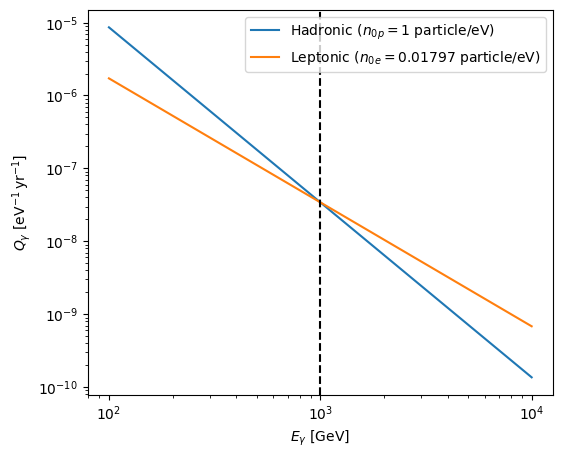

In [89]:
E_gamma_grid = np.logspace(-1, 1, 60) * u.TeV

U_rad_CMB = 0.260 * u.eV / u.cm**3
n_CMB = (U_rad_CMB / eps_i).to(1 / u.cm**3)
print(f"{n_CMB = :.2f}")


_, ax = plt.subplots(figsize=(6, 5))

ax.loglog(
    E_gamma_grid.to(u.GeV),
    q_gamma(E_gamma_grid, n_0p=1 / u.eV, method="high-energy"),
    label="Hadronic ($n_{0p} = 1~\\mathrm{particle/eV}$)",
)
n_0e_example = 0.01797 / u.eV
ax.loglog(
    E_gamma_grid.to(u.GeV),
    q_gamma_e(E_gamma_grid, n_0e=n_0e_example),
    label=f"Leptonic ($n_{{0e}} = {n_0e_example.value}~\\mathrm{{particle/eV}}$)",
)

ax.axvline(1 * u.TeV, color="k", linestyle="--")

ax.legend()
label_axes(ax, "E_\\gamma", "Q_\\gamma")
plt.show()

# Results

Normalization factor ratio $n_{0e} / n_{0p}$, satisfying the condition $q_\gamma^{(e)}(1~\text{TeV}) = q_\gamma^{(p)}(1~\text{TeV})$

In [88]:
n_0_ratio = (q_gamma(
    u.Quantity([1]) * u.TeV, n_0p=1 / u.eV, method="high-energy"
) / q_gamma_e(u.Quantity([1]) * u.TeV, n_0e=1 / u.eV))[0]

print(f"n_0e / n_0p = {n_0_ratio:.5f}")

n_0e / n_0p = 0.01797


Corresponding total energy ratio

$$
\frac{W_e}{W_p} = \frac{n_{0e}}{n_{0p}} \left( \frac{m_e}{m_p} \right)^{2 - \alpha}
$$

In [87]:
energy_ratio = n_0_ratio * (const.m_e / const.m_p) ** (2 - alpha)

print(f"W_e / W_p = {energy_ratio:.3f}")

W_e / W_p = 0.363
